In [7]:
# для автозагрузки изменений в модулях без необходимости перезагрузки kelner
%load_ext autoreload
%autoreload 2

# необходимо для корректного импорта своих модулей в JupyterLab
import sys
current_dir = sys.path[0]
project_dir = 'SF_DS_Pro'
last_position = current_dir.find(project_dir) + len(project_dir)
project_path = current_dir[:last_position]
sys.path.append(project_path)

import Handlers as hd

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
#импорт библиотек
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации

from sklearn import metrics # метрики
from sklearn import model_selection # методы разделения и валидации
from sklearn import ensemble # ансамбли

%matplotlib inline
plt.style.use('seaborn')

### На этот раз мы окунёмся в онлайн-маркетинг: будем пытаться предсказать совершение покупки пользователем во время его сессии на сайте некоторого интернет-магазина.
Набор данных вы можете скачать по [ссылке](https://lms.skillfactory.ru/assets/courseware/v1/76a66bafef0a7ce54bd384d9e91695bc/asset-v1:SkillFactory+DSPR-2.0+14JULY2021+type@asset+block/online_shoppers_intention.zip).

С подробным описанием датасета ознакомьтесь в [источнике](https://www.kaggle.com/datasets/imakash3011/online-shoppers-purchasing-intention-dataset).

In [9]:
shoppers_data = pd.read_csv('data\online_shoppers_intention.zip')

In [10]:
shoppers_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative           12330 non-null  int64  
 1   Administrative_Duration  12330 non-null  float64
 2   Informational            12330 non-null  int64  
 3   Informational_Duration   12330 non-null  float64
 4   ProductRelated           12330 non-null  int64  
 5   ProductRelated_Duration  12330 non-null  float64
 6   BounceRates              12330 non-null  float64
 7   ExitRates                12330 non-null  float64
 8   PageValues               12330 non-null  float64
 9   SpecialDay               12330 non-null  float64
 10  Month                    12330 non-null  object 
 11  OperatingSystems         12330 non-null  int64  
 12  Browser                  12330 non-null  int64  
 13  Region                   12330 non-null  int64  
 14  TrafficType           

In [11]:
TARGET_FEATURE = 'Revenue'

Конвертирую булевые признаки в численный тип

In [12]:
shoppers_data['Revenue'] = shoppers_data['Revenue'].astype('int')
shoppers_data['Weekend'] = shoppers_data['Weekend'].astype('int')

In [13]:
shoppers_data

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.200000,0.200000,0.000000,0.0,Feb,1,1,1,1,Returning_Visitor,0,0
1,0,0.0,0,0.0,2,64.000000,0.000000,0.100000,0.000000,0.0,Feb,2,2,1,2,Returning_Visitor,0,0
2,0,0.0,0,0.0,1,0.000000,0.200000,0.200000,0.000000,0.0,Feb,4,1,9,3,Returning_Visitor,0,0
3,0,0.0,0,0.0,2,2.666667,0.050000,0.140000,0.000000,0.0,Feb,3,2,2,4,Returning_Visitor,0,0
4,0,0.0,0,0.0,10,627.500000,0.020000,0.050000,0.000000,0.0,Feb,3,3,1,4,Returning_Visitor,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12325,3,145.0,0,0.0,53,1783.791667,0.007143,0.029031,12.241717,0.0,Dec,4,6,1,1,Returning_Visitor,1,0
12326,0,0.0,0,0.0,5,465.750000,0.000000,0.021333,0.000000,0.0,Nov,3,2,1,8,Returning_Visitor,1,0
12327,0,0.0,0,0.0,6,184.250000,0.083333,0.086667,0.000000,0.0,Nov,3,2,1,13,Returning_Visitor,1,0
12328,4,75.0,0,0.0,15,346.000000,0.000000,0.021053,0.000000,0.0,Nov,2,2,3,11,Returning_Visitor,0,0


В нашей таблице содержится информация о более чем 12 тысячах сессий на сайте интернет-магазина. Каждая сессия описывается 18 признаками.

Заранее удостоверимся в отсутствии пропусков:

In [14]:
shoppers_data.isnull().mean() * 100

Administrative             0.0
Administrative_Duration    0.0
Informational              0.0
Informational_Duration     0.0
ProductRelated             0.0
ProductRelated_Duration    0.0
BounceRates                0.0
ExitRates                  0.0
PageValues                 0.0
SpecialDay                 0.0
Month                      0.0
OperatingSystems           0.0
Browser                    0.0
Region                     0.0
TrafficType                0.0
VisitorType                0.0
Weekend                    0.0
Revenue                    0.0
dtype: float64

Теперь закодируем категориальные признаки с помощью простого горячего кодирования, используя уже знакомую нам функцию

In [15]:
dummy_data = pd.get_dummies(shoppers_data, drop_first=True)
dummy_data.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,...,Month_Feb,Month_Jul,Month_June,Month_Mar,Month_May,Month_Nov,Month_Oct,Month_Sep,VisitorType_Other,VisitorType_Returning_Visitor
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,...,1,0,0,0,0,0,0,0,0,1
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,...,1,0,0,0,0,0,0,0,0,1
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,...,1,0,0,0,0,0,0,0,0,1
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,...,1,0,0,0,0,0,0,0,0,1
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,...,1,0,0,0,0,0,0,0,0,1


Итак, нам необходимо предсказать целевую переменную Revenue — признак покупки. Целевой признак является бинарным категориальным, то есть мы решаем задачу бинарной классификации. В первую очередь посмотрим на соотношение классов в данных:

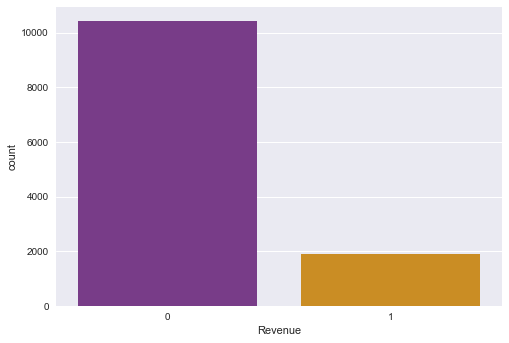

In [16]:
sns.countplot(data=dummy_data, x=TARGET_FEATURE, palette='CMRmap');

In [17]:
class_percent = dummy_data[TARGET_FEATURE].value_counts(normalize=True) * 100
print('Sessions without purchase : {:.2f}%'.format(class_percent[0]))
print('Sessions with purchase: {:.2f}%'.format(class_percent[1]))

Sessions without purchase : 84.53%
Sessions with purchase: 15.47%


Из 12 330 сессий покупкой товара завершаются лишь 15.47 %. Мы знаем, что такое соотношение классов заставляет нас смотреть на метрики для каждого из классов отдельно.

Accuracy тут нельзя использовать. В качестве метрики будем использовать F1.

По традиции разделим набор данных на матрицу наблюдений X и вектор ответов y:

In [18]:
X, y = dummy_data.drop(TARGET_FEATURE, axis=1), dummy_data[TARGET_FEATURE]

Давайте заранее определимся, как мы будем производить контроль качества наших моделей:

Разделим выборку на тренировочную и тестовую.
Будем проводить кросс-валидацию на тренировочной выборке (то есть будем делить её на тренировочные и валидационные фолды и считать среднее значение метрики по фолдам).
Итого мы будем использовать три показателя:

- значение метрики на тренировочных и валидационных фолдах кросс-валидации (по ним мы будем отслеживать переобучение модели и подбирать внешние параметры);
- значение метрики на отложенной тестовой выборке (оно будет нашим контрольным показателем).

Другими словами, мы будем сочетать hold-оut- и k-fold-подходы к валидации.

### Задание 6.2
Для начала позаботимся о создании отложенной тестовой выборки.

Разделите выборку на тренировочную и тестовую в соотношении 80/20. 

Используйте разбиение, стратифицированное по целевому признаку. 

В качестве значения параметра random_state возьмите число 42.

In [19]:
from sklearn.model_selection import train_test_split

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [21]:
X_train.shape

(9864, 26)

In [22]:
y_train.value_counts(normalize=True)

0    0.845296
1    0.154704
Name: Revenue, dtype: float64

In [23]:
X_test.shape

(2466, 26)

In [24]:
y_test.value_counts(normalize=True)

0    0.845093
1    0.154907
Name: Revenue, dtype: float64

### Задание 6.3
Коллеги посоветовали нам использовать случайный лес (Random Forest) для решения данной задачи. Давайте последуем их совету.

Создайте модель случайного леса. В качестве значения параметра random_state возьмите число 42. Остальные параметры оставьте по умолчанию.

Оцените качество такой модели с помощью кросс-валидации по пяти фолдам. Так как классы несбалансированы, используйте кросс-валидатор StratifiedKFold (перемешивать выборку не нужно).

Для проведения кросс-валидации используйте функцию cross_validate(). Набор данных (параметры X, y) — тренировочная выборка (X_train, y_train). Метрика — F1-score.

Чему равно среднее значение метрики F1 на тренировочных и валидационных фолдах? Ответ округлите до двух знаков после точки-разделителя.

In [25]:
model = ensemble.RandomForestClassifier(random_state=42)
skf = model_selection.StratifiedKFold(n_splits=5)

# Считаем метрики на кросс-валидации k-fold со стратификацией
cv_metrics = model_selection.cross_validate(
    estimator=model, # модель
    X=X_train, # матрица наблюдений X
    y=y_train, # вектор ответов y
    cv=skf, # кросс-валидатор
    scoring='f1', # метрика
    return_train_score=True # подсчёт метрики на тренировочных фолдах
)
 
print('Train k-fold mean f1: {:.2f}'.format(np.mean(cv_metrics['train_score'])))
print('Valid k-fold mean f1: {:.2f}'.format(np.mean(cv_metrics['test_score'])))

Train k-fold mean f1: 1.00
Valid k-fold mean f1: 0.65


### Задание 6.5
Попробуем использовать несколько вариаций случайного леса и с помощью кривых обучения постараемся выбрать наилучшую из них.

Создайте список из трёх следующих моделей:
- Случайный лес из деревьев максимальной глубины 5.
- Случайный лес из деревьев максимальной глубины 7.
- Случайный лес из деревьев максимальной глубины 12.

Для всех трёх моделей количество деревьев в лесу (n_estimators) возьмите равным 200, количество объектов в листе (min_samples_leaf) — 5. 
Параметр random_state = 42. Остальные параметры оставьте по умолчанию.

Постройте для каждой из моделей кривую обучения.

In [26]:
models = [
    ensemble.RandomForestClassifier(max_depth=5, n_estimators=200, min_samples_leaf=5, random_state=42),
    ensemble.RandomForestClassifier(max_depth=7, n_estimators=200, min_samples_leaf=5, random_state=42),
    ensemble.RandomForestClassifier(max_depth=12, n_estimators=200, min_samples_leaf=5, random_state=42),
]

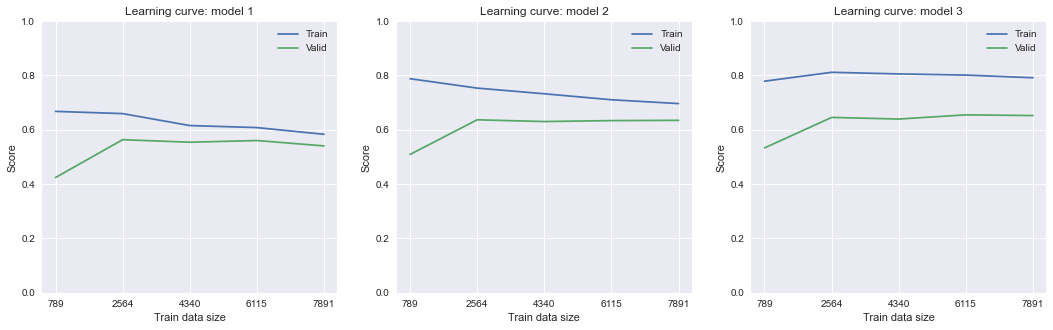

In [27]:
# Создаём объект кросс-валидатора k-fold со стратификацией
skf = model_selection.StratifiedKFold(n_splits=5)

# Визуализируем кривые обучения
fig, axes = plt.subplots(1, 3, figsize=(18, 5)) # фигура + три координатных плоскости

# Создаём цикл по списку моделей и индексам этого списка
for i, model in enumerate(models): # i — текущий индекс, model — текущая модель
    hd.plot_learning_curve(model, X_train, y_train, skf, ax=axes[i], title=f'model {i+1}')

Выбираю вторую модель. У нее меньше разброс метрики F1 между train и valid выборкой в области размера треин выборки 6115 чем у 3ей модели. А значение F1 на valid при этом больше чем у первой модели. Где разброс минимальный, но качество модели ниже всего на valid.

### Задание 6.6
Обучите случайный лес с выбранной в предыдущем задании оптимальной глубиной на тренировочной выборке. Сделайте предсказание меток классов и выведите отчёт о метриках классификации.

In [28]:
final_model = ensemble.RandomForestClassifier(
    max_depth=7, 
    n_estimators=200, 
    min_samples_leaf=5,
    random_state=42
    )

final_model.fit(X_train, y_train)

y_train_pred = final_model.predict(X_train)
y_test_pred = final_model.predict(X_test)

print('ON TRAIN:\n', metrics.classification_report(y_train, y_train_pred))
print('-' * 65)
print('ON TEST:\n', metrics.classification_report(y_test, y_test_pred))

ON TRAIN:
               precision    recall  f1-score   support

           0       0.93      0.98      0.95      8338
           1       0.85      0.58      0.69      1526

    accuracy                           0.92      9864
   macro avg       0.89      0.78      0.82      9864
weighted avg       0.92      0.92      0.91      9864

-----------------------------------------------------------------
ON TEST:
               precision    recall  f1-score   support

           0       0.91      0.98      0.94      2084
           1       0.80      0.49      0.61       382

    accuracy                           0.90      2466
   macro avg       0.86      0.74      0.78      2466
weighted avg       0.90      0.90      0.89      2466



### Задание 6.7
Попробуем повысить качество распознавания посетителей, совершивших покупку. Используем метод подбора порога вероятности с помощью PR-кривой.

Порог вероятности будем подбирать с помощью кросс-валидации.

Сделайте предсказание вероятностей принадлежности к пользователям, которые совершат покупку, на кросс-валидации на пяти фолдах. Используйте метод cross_val_predict().

Для кросс-валидации используйте случайный лес с подобранной в задании 6.5 максимальной глубиной деревьев, набор данных (параметры X, y) — тренировочная выборка (X_train, y_train).

Постройте PR-кривую и отметьте на ней точку, в которой наблюдается максимум метрики  для посетителей, которые совершат покупку. Определите порог вероятности, соответствующий этой точке.

В качестве ответа приведите значение выбранного порога вероятности. Ответ округлите до двух знаков после точки-разделителя.

In [29]:
# Создаём модель
model = ensemble.RandomForestClassifier(
    max_depth=7, 
    n_estimators=200, 
    min_samples_leaf=5,
    random_state=42
    )

# Обучаем модель
model.fit(X_train, y_train)

# Создаём кросс-валидатор k-fold со стратификацией
skf = model_selection.StratifiedKFold(n_splits=5)

# Делаем предсказание вероятностей на кросс-валидации
y_cv_proba_pred = model_selection.cross_val_predict(model, X_train, y_train, cv=skf, method='predict_proba')

In [30]:
# Выделяем столбец с вероятностями для класса 1 
y_cv_proba_pred = y_cv_proba_pred[:, 1]
y_cv_proba_pred

array([0.32978208, 0.04004348, 0.02642277, ..., 0.0115439 , 0.5210891 ,
       0.67714724])

Теперь мы можем построить PR-кривую. Для этого воспользуемся функций precision_recall_curve() из модуля metrics библиотеки sklearn. В данную функцию нужно передать истинные метки классов и предсказанные вероятности. Взамен она вернёт три массива: значения метрик precision и recall, вычисленных на различных порогах вероятности, и сами пороги вероятности:

In [31]:
# Вычисляем координаты PR-кривой
precision, recall, thresholds = metrics.precision_recall_curve(y_train, y_cv_proba_pred)

# Посмотрим на первые пять значений
print('Thresholds:', thresholds[:5])
print('Precision scores:', precision[:5])
print('Recall scores:', recall[:5])

Thresholds: [0.00108521 0.00119905 0.00126669 0.0013107  0.00134316]
Precision scores: [0.15470397 0.15471966 0.15473535 0.15475104 0.15476673]
Recall scores: [1. 1. 1. 1. 1.]


Осталось дело за малым. Вычислим значение F1-score при различных порогах вероятности и найдём такой порог вероятности, при котором она максимальна.

Сделать это можно с помощью функции argmax() из модуля numpy — она возвращает индекс максимального элемента массива.

Далее построим PR-кривую и отметим на ней точку максимума F1-score.

In [32]:
def plot_precision_recall_curve(y, y_cv_proba_pred):
    precision, recall, thresholds = metrics.precision_recall_curve(y, y_cv_proba_pred)
    
    # Вычисляем F1-score при различных threshold
    f1_scores = (2 * precision * recall) / (precision + recall)

    # Определяем индекс максимума
    idx = np.argmax(f1_scores)
    threshold_opt = thresholds[idx]

    print('Best threshold = {:.2f}, F1-Score = {:.2f}'.format(threshold_opt, f1_scores[idx]))
    
    # Строим PR-кривую
    fig, ax = plt.subplots(figsize = (16, 8)) # фигура + координатная плоскость

    # Строим линейный график зависимости precision от recall
    ax.plot(precision, recall, label='Decision Tree PR')

    # Отмечаем точку максимума F1
    ax.scatter(precision[idx], recall[idx], marker='o', color='black', label='Best F1 score')

    # Даём графику название и подписываем оси
    ax.set_title('Precision-recall curve')
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')

    # Отображаем легенду
    ax.legend()
    plt.show()
    
    return threshold_opt

Best threshold = 0.37, F1-Score = 0.69


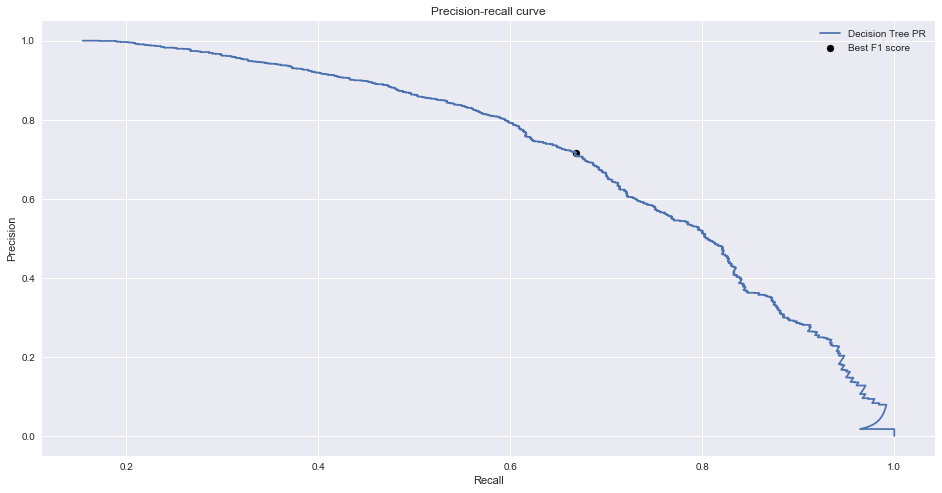

In [33]:
threshold_opt = plot_precision_recall_curve(y_train, y_cv_proba_pred)

### Задание 6.8
Сделайте предсказание классов объекта с определённым в предыдущем задании порогом вероятности. 

Выведите отчёт о метриках классификации.

In [34]:
# Из модели получую вероятности принадлежности к классам
# Оставлю только второй столбец для вероятности что класс 1
y_test_pred_proba = model.predict_proba(X_test)[:, 1]
# Через list comprehension преобразую вероятности в метки класса, используя оптимальный порог threshold_opt
# определенный через PR-кривую
y_test_pred = pd.Series([1 if i > 0.5 else 0 for i in y_test_pred_proba > threshold_opt])
# так проще преобразовать
y_test_pred = (y_test_pred > threshold_opt).astype('int')

In [35]:
print(metrics.classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.94      0.94      0.94      2084
           1       0.67      0.68      0.67       382

    accuracy                           0.90      2466
   macro avg       0.80      0.81      0.81      2466
weighted avg       0.90      0.90      0.90      2466

